# 1. Import libraries and data

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pmdarima.arima import auto_arima

In [2]:
data = pd.read_excel('data.xlsx')

In [3]:
data.set_index(pd.to_datetime(data[["YEAR", "MONTH"]].assign(DAY=1)), inplace = True)

In [4]:
data.drop(['YEAR','MONTH','HANSGN'], axis = 1, inplace = True)

In [5]:
data.head(5)

,TTT
2015-01-01,1436819
2015-02-01,1541333
2015-03-01,1680903
2015-04-01,1684774
2015-05-01,1772993


<AxesSubplot:>

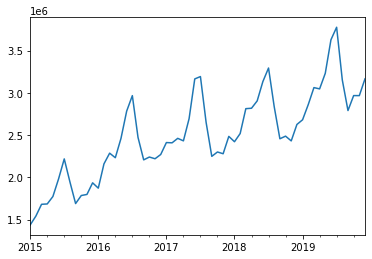

In [6]:
data['TTT'].plot()

In [7]:
train = data[:-12].copy()
test = data[-12:].copy() # last 12 months as test set

In [8]:
test

,TTT
2019-01-01,2680573
2019-02-01,2860436
2019-03-01,3061302
2019-04-01,3045879
2019-05-01,3230488
2019-06-01,3627333
2019-07-01,3775263
2019-08-01,3151724
2019-09-01,2789760
2019-10-01,2966733


# 2. Time Series Analysis

In [9]:
# Stationarity test:
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -3.968342
Critical Values at 0.05: -2.94
p-value: 0.001586
Stationary


In [10]:
kpss_test = kpss(train)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.795515
Critical Values at 0.05: 0.46
p-value: 0.010000
Not stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


<AxesSubplot:>

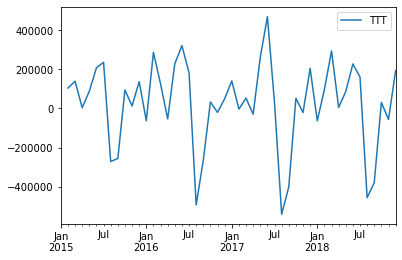

In [11]:
train1 = train - train.shift(1)
train1.plot()

In [12]:
# unit-root ("difference stationary") test:
# Difference-stationary: If a time series can be made stationary by differencing, it is said to contain a unit root.
# In essence, this means that the current value of a series yt is equal to its last value yt−1 plus an error ϵt
# i.e. yt=ayt−1+ϵt with |a|=1
# Variables that show this behaviour are also said to be integrated of order d, or I(d)
# which means that d differences are neccesary to render a series stationary.
result = adfuller(train1.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -6.515841
p-value: 0.000000
Stationary


In [13]:
# trend-stationary test:
kpss_test = kpss(train1.dropna())

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.071539
Critical Values @ 0.05: 0.46
p-value: 0.100000
Stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


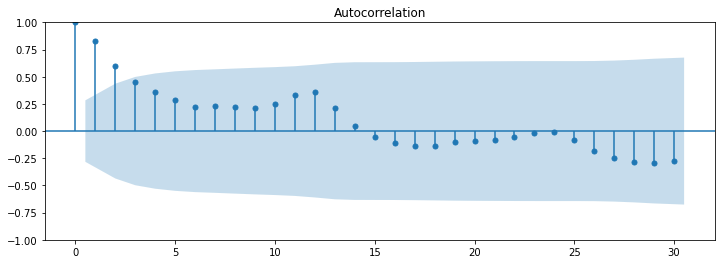

In [14]:
# Check ACF and PACF:
plt.figure(figsize=(12,4))
plot_acf(train, ax=plt.gca(), lags = 30)
plt.show()

C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


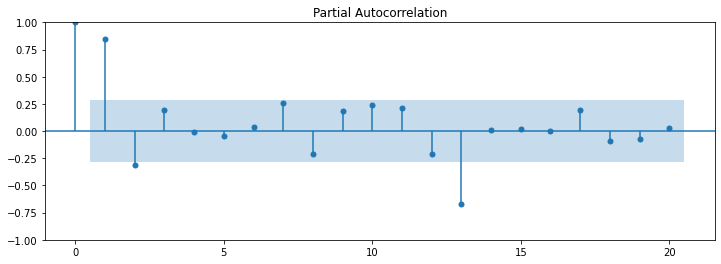

In [15]:
plt.figure(figsize=(12,4))
plot_pacf(train, ax=plt.gca(), lags = 20)
plt.show()

Conclusion:
- Because the time series is stationary after 1 differencing, d value should be 1
- Based on ACF plot, q value should be 3
- Based on PACF plot, p value should be 1

# 3. Build models

## 3.1. ARIMA without boxcox

In [94]:
model = auto_arima(train,
                   d = 3,
                   start_p = 0,
                   max_p = 13,
                   start_q = 0,
                   max_q = 3,
                   m = 12,
                   seasonal = True,
                   trace = True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(1,1,1)[12]             : AIC=919.036, Time=0.10 sec
 ARIMA(0,3,0)(0,1,0)[12]             : AIC=935.270, Time=0.01 sec
 ARIMA(1,3,0)(1,1,0)[12]             : AIC=913.656, Time=0.07 sec
 ARIMA(0,3,1)(0,1,1)[12]             : AIC=897.827, Time=0.11 sec
 ARIMA(0,3,1)(0,1,0)[12]             : AIC=902.378, Time=0.04 sec
 ARIMA(0,3,1)(1,1,1)[12]             : AIC=896.241, Time=0.16 sec
 ARIMA(0,3,1)(1,1,0)[12]             : AIC=896.091, Time=0.10 sec
 ARIMA(0,3,1)(2,1,0)[12]             : AIC=896.415, Time=0.29 sec
 ARIMA(0,3,1)(2,1,1)[12]             : AIC=898.237, Time=0.56 sec
 ARIMA(0,3,0)(1,1,0)[12]             : AIC=914.310, Time=0.05 sec
 ARIMA(1,3,1)(1,1,0)[12]             : AIC=897.064, Time=0.11 sec
 ARIMA(0,3,2)(1,1,0)[12]             : AIC=895.532, Time=0.13 sec
 ARIMA(0,3,2)(0,1,0)[12]             : AIC=897.393, Time=0.06 sec
 ARIMA(0,3,2)(2,1,0)[12]             : AIC=896.495, Time=0.36 sec
 ARIMA(0,3,2)(1,1,1)[12]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   48
Model:             SARIMAX(1, 3, 3)x(1, 1, [1], 12)   Log Likelihood                -438.808
Date:                              Fri, 03 Feb 2023   AIC                            891.615
Time:                                      10:41:31   BIC                            902.091
Sample:                                  01-01-2015   HQIC                           895.140
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8333      0.441     -1.890      0.059      -1.697       0.031
ma.L1         -0.4745      0.431     -1.102      0.270      -1.318       0.369
ma.L2         -0.8261      0.605     -1.366      0.172      -2.011       0.359
ma.L3          0.3280      0.218      1.503      0.133      -0.100       0.756
ar.S.L12      -0.8129      0.953     -0.853      0.394      -2.681       1.055
ma.S.L12       0.7021      1.117      0.629      0.529      -1.486       2.891
sigma2      2.836e+10   1.94e-11   1.47e+21      0.000    2.84e+10    2.84e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.97
Prob(Q):                              0.85   Prob(JB):                         0.62
Heteroskedasticity (H):               1.32   Skew:                            -0.39
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.24e+37. Standard errors may be unstable.
"""

In [55]:
# Predict using the best model from auto_arima:
test['predict'] = pd.Series(model.predict(12).astype('int64'))

In [56]:
test

,TTT,predict
2019-01-01,2680573,2590299
2019-02-01,2860436,2672974
2019-03-01,3061302,2933866
2019-04-01,3045879,2933991
2019-05-01,3230488,3045351
2019-06-01,3627333,3307231
2019-07-01,3775263,3449552
2019-08-01,3151724,2980691
2019-09-01,2789760,2597626
2019-10-01,2966733,2631500


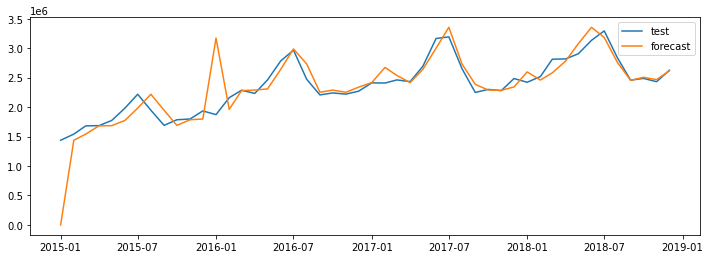

In [57]:
# Plot train vs forecast
plt.figure(figsize=(12,4))
plt.plot(train, label='test')
plt.plot(model.predict_in_sample(), label='forecast')
plt.legend(loc='best')
plt.show()

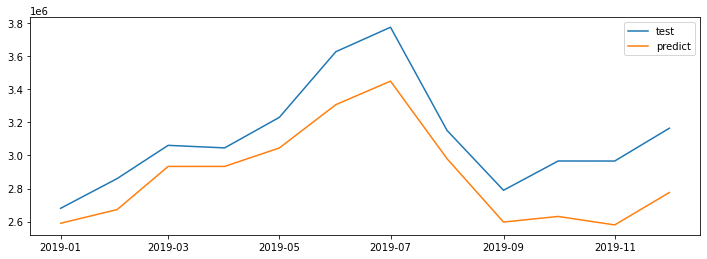

In [58]:
# Plot test vs forecast
plt.figure(figsize=(12,4))
plt.plot(test['TTT'], label='test')
plt.plot(test['predict'], label='predict')
plt.legend(loc='best')
plt.show()

In [59]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(test['TTT'], test['predict'])).round(2)
mape = np.round(np.mean(np.abs(test['TTT']-test['predict'])/test['TTT'])*100,2)

In [60]:
results = pd.DataFrame({'Method':'ARIMA', 'MAPE': [mape], 'RMSE': [rmse]})
results

,Method,MAPE,RMSE
0,ARIMA,7.49,257177.27


## 3.2. ARIMA with boxcox (trend stationary)

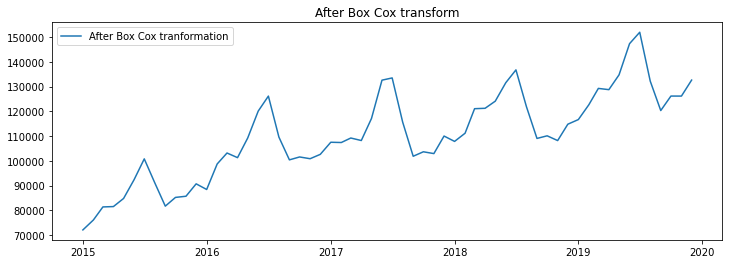

In [23]:
data_boxcox = pd.Series(boxcox(data['TTT'])[0], index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [24]:
# Stationarity test:
result = adfuller(data_boxcox)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -2.315488
Critical Values at 0.05: -2.92
p-value: 0.167021
Not stationary


In [25]:
kpss_test = kpss(data_boxcox)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 1.059631
Critical Values at 0.05: 0.46
p-value: 0.010000
Not stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


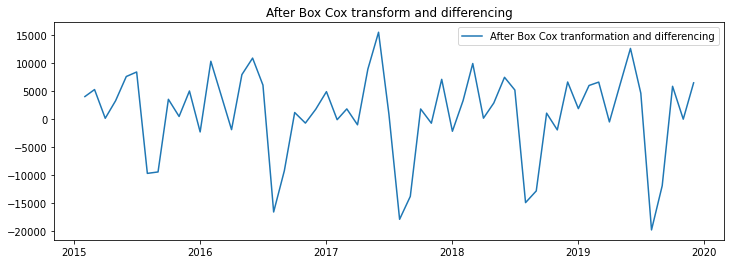

In [26]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(1), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [27]:
data_boxcox_diff.dropna(inplace=True)

In [28]:
# Stationarity test:
result = adfuller(data_boxcox_diff)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -1.697966
Critical Values at 0.05: -2.93
p-value: 0.432161
Not stationary


In [29]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.049471
Critical Values at 0.05: 0.46
p-value: 0.100000
Stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


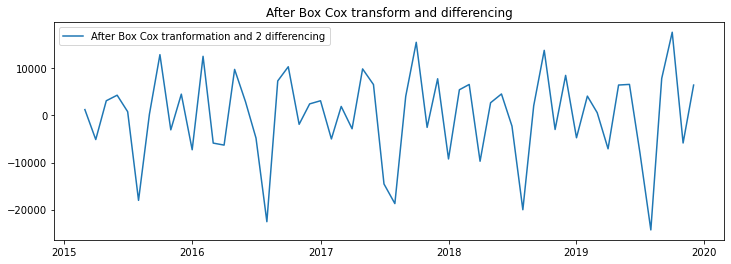

In [30]:
data_boxcox_diff2 = pd.Series(data_boxcox_diff - data_boxcox_diff.shift(1), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff2, label='After Box Cox tranformation and 2 differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [31]:
data_boxcox_diff2.dropna(inplace=True)

In [32]:
# Stationarity test:
result = adfuller(data_boxcox_diff2)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -10.868264
Critical Values at 0.05: -2.93
p-value: 0.000000
Stationary


In [33]:
kpss_test = kpss(data_boxcox_diff2)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.362500
Critical Values at 0.05: 0.46
p-value: 0.093319
Stationary


In [34]:
data_boxcox_diff2.tail()

2019-08-01   -24333.806447
2019-09-01     7867.386826
2019-10-01    17698.487960
2019-11-01    -5849.762106
2019-12-01     6464.926196
dtype: float64

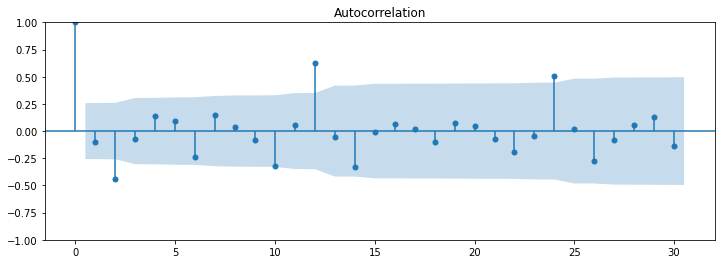

In [35]:
# Check ACF and PACF:
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff2, ax=plt.gca(), lags = 30)
plt.show()

C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


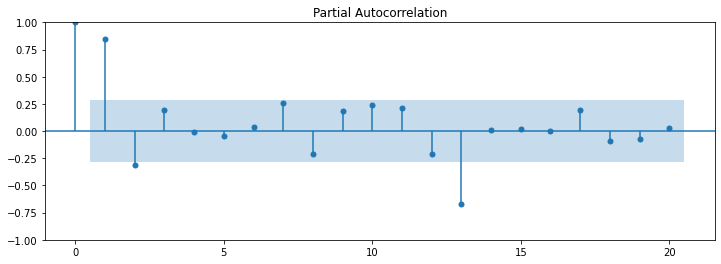

In [36]:
plt.figure(figsize=(12,4))
plot_pacf(train, ax=plt.gca(), lags = 20)
plt.show()

Conclusion:
- Because the time series is stationary after 2 differencing, d value should be 2
- Based on ACF plot, q value should be 0
- Based on PACF plot, p value should be 1

In [86]:
train_data_boxcox_diff = data_boxcox[:-12]
test_data_boxcox_diff = data_boxcox[-12:]

In [87]:
test_data_boxcox_diff

2019-01-01    116659.622426
2019-02-01    122646.749958
2019-03-01    129231.894689
2019-04-01    128729.861157
2019-05-01    134701.756453
2019-06-01    147282.469108
2019-07-01    151889.972178
2019-08-01    132163.668800
2019-09-01    120304.752248
2019-10-01    126144.323656
2019-11-01    126134.132959
2019-12-01    132588.868457
dtype: float64

In [88]:
model = auto_arima(train_data_boxcox_diff,
                   d = 2,
                   start_p = 0,
                   max_p = 13,
                   start_q = 0,
                   max_q = 3,
                   m = 12,
                   seasonal = True,
                   trace = True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=684.149, Time=0.11 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=695.637, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=683.153, Time=0.06 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=678.580, Time=0.08 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=inf, Time=0.03 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=679.350, Time=0.14 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=679.963, Time=0.17 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=677.982, Time=0.09 sec
 ARIMA(0,2,1)(2,1,0)[12]             : AIC=679.636, Time=0.34 sec
 ARIMA(0,2,1)(2,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,2,0)(1,1,0)[12]             : AIC=682.262, Time=0.03 sec
 ARIMA(1,2,1)(1,1,0)[12]             : AIC=674.036, Time=0.14 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,1)(2,1,0)[12]             : AIC=674.343, Time=0.42 sec
 ARIMA(1,2,1)(1,1,1)[12]             : AIC=67

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 12)   Log Likelihood                -331.978
Date:                            Fri, 03 Feb 2023   AIC                            673.956
Time:                                    10:38:00   BIC                            681.588
Sample:                                01-01-2015   HQIC                           676.559
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3962      0.253      1.564      0.118      -0.100       0.893
ma.L1         -0.9590      0.190     -5.047      0.000      -1.332      -0.587
ar.S.L12      -0.7040      1.422     -0.495      0.621      -3.491       2.083
ma.S.L12       0.5929      1.576      0.376      0.707      -2.496       3.682
sigma2      2.571e+07   2.98e-08   8.64e+14      0.000    2.57e+07    2.57e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.31
Prob(Q):                              0.89   Prob(JB):                         0.85
Heteroskedasticity (H):               1.47   Skew:                            -0.07
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.3e+31. Standard errors may be unstable.
"""

In [89]:
# Predict using the best model from auto_arima:
test['predict_boxcox'] = pd.Series(model.predict(12).astype('int64'))
test['predict'] = inv_boxcox(test['predict_boxcox'],boxcox(data['TTT'])[1])

In [91]:
test

,TTT,predict,predict_boxcox
2019-01-01,2680573,2.715552e+06,117831
2019-02-01,2860436,2.750053e+06,118983
2019-03-01,3061302,2.990366e+06,126918
2019-04-01,3045879,2.962360e+06,126001
2019-05-01,3230488,3.035755e+06,128400
2019-06-01,3627333,3.271260e+06,136010
2019-07-01,3775263,3.383333e+06,139587
2019-08-01,3151724,2.879221e+06,123267
2019-09-01,2789760,2.447592e+06,108765
2019-10-01,2966733,2.457203e+06,109094


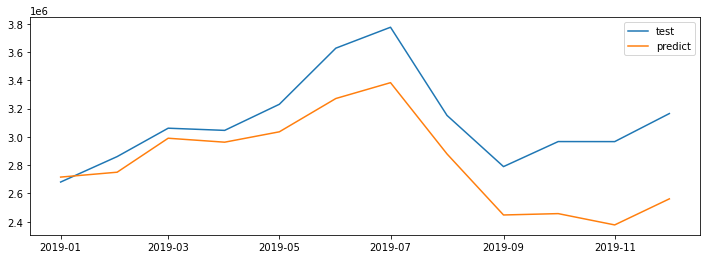

In [92]:
# Plot test vs forecast
plt.figure(figsize=(12,4))
plt.plot(test['TTT'], label='test')
plt.plot(test['predict'], label='predict')
plt.legend(loc='best')
plt.show()

In [93]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(test['TTT'], test['predict'])).round(2)
mape = np.round(np.mean(np.abs(test['TTT']-test['predict'])/test['TTT'])*100,2)
tempResults = pd.DataFrame({'Method':'ARIMA with boxcox', 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,ARIMA,7.49,257177.27
0,ARIMA with boxcox,9.45,354215.88
